# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [174]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [175]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [176]:
import pandas as pd

pd.DataFrame(blocks['3,4'].to_matrix())

,0,1,2,3,4,5,6,7
0,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [177]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [178]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size**2)] for j in range(size**2)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]

<ipython-input-178-ce06f5abc6d5>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-178-ce06f5abc6d5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [179]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483366
(-3.340847617248337+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [180]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [181]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

def Ui_dagger(cir_i,phi_i):  
    
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q):
        cir_i.ry(-phi_i[q],q)
    
    return cir_i

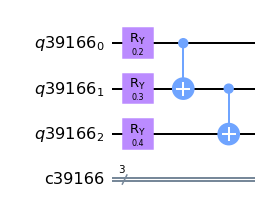

In [182]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

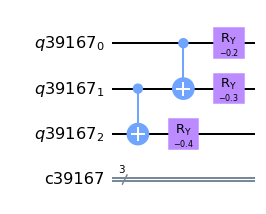

In [183]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)

tst_dagger = Ui_dagger(cir_i,[0.2,0.3,0.4])
tst_dagger.draw(output = 'mpl')

In [184]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

def U_dagger(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui_dagger(cir,phi_b[T-1-t])
    return cir

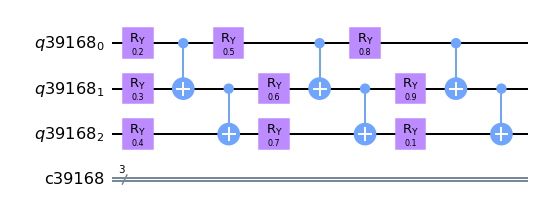

In [185]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

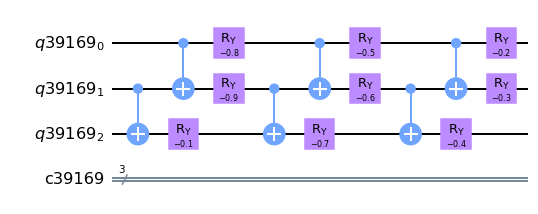

In [186]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U_dagger(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [230]:
#number of blocks
T = 2

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index

Instead of using circuits to find $E$ I will convert $U$ into a statevector and each block into a matrix.  This should run faster so that we can explore the parameters in SPSA.

In [231]:
import copy

In [232]:
from qiskit import quantum_info as qi

def bkt(psi2,h,psi1):
    return np.dot(np.conjugate(psi2),np.dot(h,psi1))

psi1 = qi.Statevector.from_instruction(tst)
h00 = blocks['0,0'].to_matrix()

bkt(psi1,h00,psi1)


def E_From_Matrix(phi,blocks):
    E = 0
    for key in list(blocks.keys()):
        qr = QuantumRegister(Q)
        cr = ClassicalRegister(Q)
        cir0 = QuantumCircuit(qr , cr)
        a = int(key.split(',')[0])
        b = int(key.split(',')[1])
        w = 1
        if a != b:
            w = 2
        cir = copy.deepcopy(cir0)
        psi_1 = qi.Statevector.from_instruction(U(cir,phi[b])).data
        h = blocks[key].to_matrix()
        cir = copy.deepcopy(cir0)
        psi_2 = qi.Statevector.from_instruction(U(cir,phi[a])).data
        E_key = bkt(psi_2,h,psi_1)
        E += w*E_key
    return E/bL
            

In [233]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
qi.Statevector.from_instruction(U(cir,phi[0])).data

E_From_Matrix(phi,blocks)

(-0.3333333333333333+0j)

For a sanity check, let's compare this to simple matrix multiplication

In [234]:
all_down = [0 for i in range(len(H))]
for b in range(bL):
    all_down[bL*b + 1] = 1/np.sqrt(bL)
    
np.dot(all_down,np.dot(H,all_down))

-0.3333333333333334

# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [238]:
def SPSA(k_max):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.2
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_A = E_From_Matrix(phi_k + c_k*Delta_k ,blocks)
        E_B = E_From_Matrix(phi_k - c_k*Delta_k ,blocks)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = E_From_Matrix(phi_k,blocks)
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
    return E_l,phi_k

In [239]:
El,phi_f = SPSA(500)

k= 0 c_k= 0.4 a_k= 0.12351225929839313 g= 0.8866419151681469 E_A= (0.8445800339514281+0j) E_B= (0.1352665018169106+0j) E_f= (-0.3376455829458417+0j)
k= 1 c_k= 0.372954594574733 a_k= 0.12137089799839414 g= -0.11660072774447094 E_A= (0.5184901895972139+0j) E_B= (0.6054637438833299+0j) E_f= (-0.3406885765313724+0j)
k= 2 c_k= 0.3579898757427053 a_k= 0.11943383615535001 g= -0.5180928739455759 E_A= (0.33500362738298156+0j) E_B= (0.7059476345168971+0j) E_f= (-0.32713991685897437+0j)
k= 3 c_k= 0.34773782403600867 a_k= 0.11766796983576779 g= 0.9894041901969469 E_A= (0.7627996119456015+0j) E_B= (0.07469309156321038+0j) E_f= (-0.37926476472687276+0j)
k= 4 c_k= 0.33998833831625347 a_k= 0.11604746356999064 g= 0.30341998800944675 E_A= (0.2650111186574903+0j) E_B= (0.05869260358695155+0j) E_f= (-0.3879544494486758+0j)
k= 5 c_k= 0.3337849224236992 a_k= 0.1145517897979757 g= -0.7632219115081441 E_A= (0.05356442117200885+0j) E_B= (0.5630683542216355+0j) E_f= (-0.4279062150205085+0j)
k= 6 c_k= 0.32862839

k= 49 c_k= 0.26944121046347563 a_k= 0.08782569482053167 g= 0.3558509074859985 E_A= (-1.0434001541882956+0j) E_B= (-1.235161952703403+0j) E_f= (-1.4845185279891124+0j)
k= 50 c_k= 0.26890284899123323 a_k= 0.08753438782299362 g= -0.08558842801247256 E_A= (-0.9762910710368191+0j) E_B= (-0.9302611267703492+0j) E_f= (-1.4858407835684804+0j)
k= 51 c_k= 0.268375986369122 a_k= 0.08724876054153671 g= -1.1475424516203048 E_A= (-1.278230840235177+0j) E_B= (-0.6622851655270974+0j) E_f= (-1.5143071430909063+0j)
k= 52 c_k= 0.267860162826851 a_k= 0.08696861326933238 g= -1.128716168353988 E_A= (-1.2912566111968298+0j) E_B= (-0.6865804179156326+0j) E_f= (-1.5608156156187427+0j)
k= 53 c_k= 0.26735494522142605 a_k= 0.08669375635146866 g= 0.22710670572824823 E_A= (-1.129137751675629+0j) E_B= (-1.2505739534144176+0j) E_f= (-1.5620619426814892+0j)
k= 54 c_k= 0.2668599250350944 a_k= 0.08642400953121344 g= 0.17944767782452617 E_A= (-1.0942277654254382+0j) E_B= (-1.1900025531293879+0j) E_f= (-1.5628646169661908

k= 98 c_k= 0.2514784857754605 a_k= 0.0778945853080328 g= -0.649345855524216 E_A= (-1.756418308301232+0j) E_B= (-1.4298252833176304+0j) E_f= (-2.0386783957425676+0j)
k= 99 c_k= 0.25122334352532716 a_k= 0.07775173088699987 g= -0.4858541440209676 E_A= (-1.7871783620488988+0j) E_B= (-1.5430625569957321+0j) E_f= (-2.0517370119294362+0j)
k= 100 c_k= 0.2509709950555822 a_k= 0.07761042772682393 g= 0.323082294070933 E_A= (-1.5079591229134073+0j) E_B= (-1.6701276925690518+0j) E_f= (-2.0559853810334268+0j)
k= 101 c_k= 0.2507213825637901 a_k= 0.07747064523280192 g= 0.5103656064299283 E_A= (-1.3454911372898044+0j) E_B= (-1.601410278204042+0j) E_f= (-2.063737684938747+0j)
k= 102 c_k= 0.25047444999544133 a_k= 0.07733235367999454 g= -0.5878356358983263 E_A= (-1.9697378169551407+0j) E_B= (-1.6752622017764331+0j) E_f= (-2.0753508128259623+0j)
k= 103 c_k= 0.25023014297472496 a_k= 0.07719552418106111 g= 0.39632400496105713 E_A= (-1.5533932122027727+0j) E_B= (-1.7517376370542146+0j) E_f= (-2.08386854997758

k= 147 c_k= 0.24147020903681907 a_k= 0.07229361154661569 g= 0.10017349471032119 E_A= (-1.8553256279417982+0j) E_B= (-1.9037034573570981+0j) E_f= (-2.428721313390017+0j)
k= 148 c_k= 0.24130603199060283 a_k= 0.07220199101486784 g= -0.6016179091777153 E_A= (-2.0295648779593205+0j) E_B= (-1.7392168170830058+0j) E_f= (-2.4407616754812764+0j)
k= 149 c_k= 0.24114306363445936 a_k= 0.07211105993518374 g= 0.026205064841800324 E_A= (-1.8212123662688335+0j) E_B= (-1.8338507055062163+0j) E_f= (-2.4405723406265825+0j)
k= 150 c_k= 0.24098128710040054 a_k= 0.07202080885867242 g= -0.37847083526034037 E_A= (-2.0686075655007023+0j) E_B= (-1.8861987874787014+0j) E_f= (-2.4444282430572626+0j)
k= 151 c_k= 0.24082068586559263 a_k= 0.07193122852360953 g= -0.1995149036586533 E_A= (-2.050473666595692+0j) E_B= (-1.9543790347167231+0j) E_f= (-2.447132651087194+0j)
k= 152 c_k= 0.24066124374307757 a_k= 0.07184230985060167 g= -0.22683145831516185 E_A= (-2.100760607336301+0j) E_B= (-1.9915815255799352+0j) E_f= (-2.45

k= 196 c_k= 0.2345950814950722 a_k= 0.06847309463791071 g= -0.143812756613592 E_A= (-2.009449806617691+0j) E_B= (-1.9419742759020977+0j) E_f= (-2.535087460108019+0j)
k= 197 c_k= 0.23447514176663659 a_k= 0.06840679847016762 g= 0.0010690997088553655 E_A= (-1.9561808694209175+0j) E_B= (-1.9566822240325106+0j) E_f= (-2.5350858615776737+0j)
k= 198 c_k= 0.23435586712929732 a_k= 0.06834088399837632 g= 0.17888902125849016 E_A= (-2.0758792194068922+0j) E_B= (-2.1597266028007818+0j) E_f= (-2.5363543669162802+0j)
k= 199 c_k= 0.23423725058049316 a_k= 0.0682753472143551 g= -0.15429727127846588 E_A= (-1.9902771469271867+0j) E_B= (-1.917992809734506+0j) E_f= (-2.536694399757354+0j)
k= 200 c_k= 0.23411928522594053 a_k= 0.06821018417084462 g= -0.39556544865276805 E_A= (-2.1802471523783007+0j) E_B= (-1.9950281521809716+0j) E_f= (-2.540476067755458+0j)
k= 201 c_k= 0.23400196427742995 a_k= 0.06814539098029829 g= 0.3988875184044758 E_A= (-2.040174976994572+0j) E_B= (-2.2268559026593655+0j) E_f= (-2.5433301

k= 245 c_k= 0.22939056205499744 a_k= 0.06561056272959805 g= -0.026877566744283588 E_A= (-2.2039110772452926+0j) E_B= (-2.1915801569610087+0j) E_f= (-2.5643525315262425+0j)
k= 246 c_k= 0.2292965915369422 a_k= 0.06555916867880195 g= -0.0345344253468745 E_A= (-2.2067388524596225+0j) E_B= (-2.190901600414172+0j) E_f= (-2.5643978138521017+0j)
k= 247 c_k= 0.2292030389611117 a_k= 0.06550801424086235 g= -0.3443035528449559 E_A= (-2.271622314763139+0j) E_B= (-2.1137914734887957+0j) E_f= (-2.567961384750749+0j)
k= 248 c_k= 0.2291099007946226 a_k= 0.06545709737638034 g= 0.39832218709053047 E_A= (-2.06855759604887+0j) E_B= (-2.251076709586087+0j) E_f= (-2.5715416232463215+0j)
k= 249 c_k= 0.22901717354849255 a_k= 0.06540641607110383 g= -0.11128208334141594 E_A= (-2.2647666220896934+0j) E_B= (-2.2137956057028156+0j) E_f= (-2.5722453974752266+0j)
k= 250 c_k= 0.22892485377692168 a_k= 0.06535596833552226 g= -0.27942029245859856 E_A= (-2.0852687110479518+0j) E_B= (-1.957336211861173+0j) E_f= (-2.5718394

k= 294 c_k= 0.22522052563003578 a_k= 0.06334111848909627 g= -0.09099233254189655 E_A= (-2.3025309627529404+0j) E_B= (-2.2615442808261625+0j) E_f= (-2.597337413490326+0j)
k= 295 c_k= 0.2251435597830072 a_k= 0.06329945764194023 g= -0.13053272540214444 E_A= (-2.2098229525408284+0j) E_B= (-2.1510457476103952+0j) E_f= (-2.5977110413510154+0j)
k= 296 c_k= 0.22506687968680195 a_k= 0.06325795998680635 g= 0.06456022419145038 E_A= (-2.1592499184367155+0j) E_B= (-2.188310654858016+0j) E_f= (-2.59803005142814+0j)
k= 297 c_k= 0.22499048332373206 a_k= 0.06321662435599024 g= 0.0460831426060317 E_A= (-2.199894986703155+0j) E_B= (-2.2206315237591703+0j) E_f= (-2.598175578293178+0j)
k= 298 c_k= 0.22491436869706707 a_k= 0.06317544959389973 g= 0.13739798671802583 E_A= (-2.133159577531565+0j) E_B= (-2.1949651404174304+0j) E_f= (-2.597621113665064+0j)
k= 299 c_k= 0.2248385338307471 a_k= 0.0631344345568905 g= -0.2199005297612978 E_A= (-2.0967106441258045+0j) E_B= (-1.997826418725535+0j) E_f= (-2.595827049504

k= 343 c_k= 0.22175202204182284 a_k= 0.06147242418420482 g= -0.005256639684912455 E_A= (-2.229271629481642+0j) E_B= (-2.226940288523093+0j) E_f= (-2.610848183610605+0j)
k= 344 c_k= 0.22168701859591308 a_k= 0.061437579436041306 g= 0.10961805744064597 E_A= (-2.164951375518232+0j) E_B= (-2.2135531761948166+0j) E_f= (-2.6104377119921143+0j)
k= 345 c_k= 0.22162222226557235 a_k= 0.06140285237216429 g= -0.04007754363594909 E_A= (-2.273445571681459+0j) E_B= (-2.2556814231143703+0j) E_f= (-2.6105162744162147+0j)
k= 346 c_k= 0.2215576317951376 a_k= 0.061368242266204805 g= -0.005088118218819678 E_A= (-2.08371831472986+0j) E_B= (-2.0814636918841494+0j) E_f= (-2.6104892546081815+0j)
k= 347 c_k= 0.22149324594014944 a_k= 0.0613337483982958 g= -0.14154933190712282 E_A= (-2.0550136055535155+0j) E_B= (-1.9923091635839791+0j) E_f= (-2.612112565694102+0j)
k= 348 c_k= 0.22142906346722022 a_k= 0.061299370054996076 g= 0.12320143305736984 E_A= (-2.2118004316618567+0j) E_B= (-2.2663611875412824+0j) E_f= (-2.61

k= 392 c_k= 0.21878943347573884 a_k= 0.05989129192031186 g= 0.18545893570825095 E_A= (-2.0998045986118523+0j) E_B= (-2.1809575095650957+0j) E_f= (-2.6312480160873473+0j)
k= 393 c_k= 0.21873328377055276 a_k= 0.05986146501081311 g= 0.08591024997066064 E_A= (-2.2859315458900187+0j) E_B= (-2.323514408061282+0j) E_f= (-2.631352920790236+0j)
k= 394 c_k= 0.21867729075224962 a_k= 0.05983172663840322 g= 0.033358823049257025 E_A= (-2.070280022556585+0j) E_B= (-2.0848696566507754+0j) E_f= (-2.6314488522021984+0j)
k= 395 c_k= 0.2186214535885725 a_k= 0.059802076322633124 g= 0.18574783479505794 E_A= (-2.3558853926961625+0j) E_B= (-2.4371023159838137+0j) E_f= (-2.6318607235562044+0j)
k= 396 c_k= 0.2185657714537727 a_k= 0.05977251358683613 g= -0.09061528250770513 E_A= (-2.427212944405854+0j) E_B= (-2.3876021461522576+0j) E_f= (-2.632251087385881+0j)
k= 397 c_k= 0.21851024352854267 a_k= 0.05974303795808894 g= -0.011399123494045812 E_A= (-2.226024622663179+0j) E_B= (-2.2210429721617873+0j) E_f= (-2.6323

k= 441 c_k= 0.21620829009131218 a_k= 0.058525774584951284 g= 0.23603365375377924 E_A= (-2.085309136590801+0j) E_B= (-2.18737400195502+0j) E_f= (-2.645603372685631+0j)
k= 442 c_k= 0.2161589464649983 a_k= 0.05849978326305746 g= 0.25278055719735537 E_A= (-2.0363609170631483+0j) E_B= (-2.1456424749243794+0j) E_f= (-2.6475577686286544+0j)
k= 443 c_k= 0.2161097253216398 a_k= 0.058473860758547776 g= -0.07219960859186274 E_A= (-2.211048754236394+0j) E_B= (-2.1798426790741594+0j) E_f= (-2.6480843017807243+0j)
k= 444 c_k= 0.21606062608236656 a_k= 0.058448006738234706 g= 0.025409505692589394 E_A= (-2.235937600964711+0j) E_B= (-2.24691758838148+0j) E_f= (-2.6482346882430026+0j)
k= 445 c_k= 0.21601164817233734 a_k= 0.058422220871271656 g= 0.06943476770986665 E_A= (-2.1675476230447566+0j) E_B= (-2.1975450602717+0j) E_f= (-2.6481765666281274+0j)
k= 446 c_k= 0.2159627910207029 a_k= 0.05839650282913145 g= -0.014898129560938262 E_A= (-2.2246269832712335+0j) E_B= (-2.218192099989297+0j) E_f= (-2.64828009

k= 490 c_k= 0.21392461576892882 a_k= 0.05732744848822447 g= 0.11074338634459055 E_A= (-2.1086120917189315+0j) E_B= (-2.1559935644643646+0j) E_f= (-2.66953242950491+0j)
k= 491 c_k= 0.21388066017622928 a_k= 0.05730447638032358 g= -0.15584351433301025 E_A= (-2.318987333484881+0j) E_B= (-2.252323506025425+0j) E_f= (-2.6706387102065765+0j)
k= 492 c_k= 0.21383680283769652 a_k= 0.05728155916595663 g= 0.09378305982997877 E_A= (-2.2909048501086247+0j) E_B= (-2.331013389457383+0j) E_f= (-2.671823330894444+0j)
k= 493 c_k= 0.21379304333507107 a_k= 0.05725869660520972 g= 0.23294061544139913 E_A= (-2.2715798015981017+0j) E_B= (-2.371181967781224+0j) E_f= (-2.6724062914902693+0j)
k= 494 c_k= 0.213749381252716 a_k= 0.05723588845969086 g= -0.1706523448069786 E_A= (-2.3918215142414945+0j) E_B= (-2.318867848017861+0j) E_f= (-2.672672719488061+0j)
k= 495 c_k= 0.21370581617759538 a_k= 0.05721313449251733 g= 0.20025663064628346 E_A= (-2.2985851692148698+0j) E_B= (-2.3841771826093483+0j) E_f= (-2.67153272030

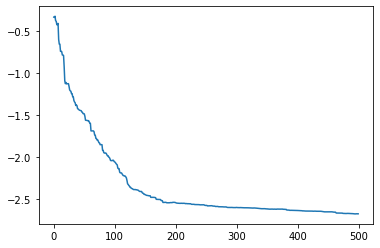

In [240]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [228]:
E_From_Matrix(phi_f,blocks)

(-2.1141884303312697+0j)

In [229]:
np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000